In [ ]:
pip install torch torchvision scikit-learn pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
#we will be using pytorch as pytorch has oxford pet dataset built into
#the framework, which allows for easy data augmentation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
#we will be using sklearn and numpy to show accuracy data and precision
#f1 scores, which we can use for evaluating our model training
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
from PIL import Image

#we were advised to use a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#here, we are going to transform our data to make our model more robust
#change color so that all images are uniform when being used to train model
#create object to store validation and training transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download and load the dataset
def load_oxford_pet_dataset(data_dir='./oxford_pet'):
    if not os.path.exists(data_dir):
      #creating directory to store our dataset in colab
        os.makedirs(data_dir)
#access train transformation from above
    train_dataset = datasets.OxfordIIITPet(
        root=data_dir,
        split='trainval',
        transform=data_transforms['train'],
        download=True
    )
#same as above
    val_dataset = datasets.OxfordIIITPet(
        root=data_dir,
        split='test',
        transform=data_transforms['val'],
        download=True
    )

    return train_dataset, val_dataset

#load the dataset
train_dataset, val_dataset = load_oxford_pet_dataset()

#create data loaders
#since colab offers a GPU, we set pin memory to true to take advantage of GPU cores as well
#importance of shuffle since dogs are more represented in this dataset, and with each epoch data is in a different order
#also use num workers set at 4 indicating working with more threads,since data is loaded in parallel which takes advantage of cores
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
#do not shuffle since validation needs to be consistent every time, and shuffling can lead to fluctuations in accuracy
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

#load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

#freeze earlier layers
for param in model.parameters():
    param.requires_grad = False

#get the number of classe (37)
num_classes = len(train_dataset.classes)

#modify the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

#despite Resnet already being pretrianed and having its own weights,we
#unfreeze the final layers, so that resnet learns new patterns from our dataset
#and layers can be trained again
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

#move model to device(GPU/CPU, here is GPU since using colab)
model = model.to(device)

#define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=0.0001,
                      weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

#training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_acc = 0.0
    best_model_wts = model.state_dict()
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            #gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset) * 100  #convert to percentage

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%')

        #validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset) * 100  #convert to percentage

        #calculate additional metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')
        print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')

        #update learning rate
        scheduler.step(val_loss)

        #early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break

    print(f'Best val Acc: {best_acc:.2f}%')
    model.load_state_dict(best_model_wts)
    return model

#function to test the model on specific images
def predict_breed(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.softmax(outputs, dim=1)[0][predicted].item() * 100  #convert to percentage

    return class_names[predicted.item()], confidence

#train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5)

#save the model
torch.save(model.state_dict(), 'pet_breed_classifier.pth')

100%|██████████| 792M/792M [00:49<00:00, 16.0MB/s]


Extracting oxford_pet/oxford-iiit-pet/images.tar.gz to oxford_pet/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 7.76MB/s]


Extracting oxford_pet/oxford-iiit-pet/annotations.tar.gz to oxford_pet/oxford-iiit-pet


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch 1/25
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 2.3686 Acc: 39.73%
Val Loss: 0.6705 Acc: 86.29%
Precision: 0.8690 Recall: 0.8629 F1: 0.8590
Epoch 2/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.2496 Acc: 68.10%
Val Loss: 0.4359 Acc: 88.77%
Precision: 0.8918 Recall: 0.8877 F1: 0.8847
Epoch 3/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.9958 Acc: 72.74%
Val Loss: 0.3803 Acc: 89.51%
Precision: 0.8999 Recall: 0.8951 F1: 0.8936
Epoch 4/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.8965 Acc: 75.46%
Val Loss: 0.3838 Acc: 89.42%
Precision: 0.8978 Recall: 0.8942 F1: 0.8922
Epoch 5/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.8362 Acc: 77.09%
Val Loss: 0.3630 Acc: 89.64%
Precision: 0.9026 Recall: 0.8964 F1: 0.8952
Epoch 6/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.8064 Acc: 78.15%
Val Loss: 0.3787 Acc: 89.45%
Precision: 0.8976 Recall: 0.8945 F1: 0.8930
Epoch 7/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.7555 Acc: 79.32%
Val Loss: 0.3756 Acc: 89.92%
Precision: 0.9074 Recall: 0.8992 F1: 0.8988
Epoch 8/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.7281 Acc: 79.27%
Val Loss: 0.3624 Acc: 89.13%
Precision: 0.9003 Recall: 0.8913 F1: 0.8911
Epoch 9/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.7063 Acc: 79.95%
Val Loss: 0.3755 Acc: 89.86%
Precision: 0.9065 Recall: 0.8986 F1: 0.8990
Epoch 10/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6731 Acc: 81.06%
Val Loss: 0.3466 Acc: 90.08%
Precision: 0.9053 Recall: 0.9008 F1: 0.9007
Epoch 11/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6556 Acc: 80.76%
Val Loss: 0.3515 Acc: 90.05%
Precision: 0.9074 Recall: 0.9005 F1: 0.9002
Epoch 12/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6222 Acc: 82.45%
Val Loss: 0.3907 Acc: 88.58%
Precision: 0.8962 Recall: 0.8858 F1: 0.8851
Epoch 13/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6340 Acc: 82.15%
Val Loss: 0.3451 Acc: 89.94%
Precision: 0.9051 Recall: 0.8994 F1: 0.8979
Epoch 14/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6107 Acc: 82.80%
Val Loss: 0.3806 Acc: 88.93%
Precision: 0.8927 Recall: 0.8893 F1: 0.8867
Epoch 15/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5848 Acc: 83.26%
Val Loss: 0.3457 Acc: 90.05%
Precision: 0.9053 Recall: 0.9005 F1: 0.8986
Early stopping triggered after 15 epochs
Best val Acc: 90.08%


In [ ]:
#define our test prediction function which we will use to validate the model
#using images from google of different pet breeds outside the dataset
def test_prediction(image_path):
    prediction, confidence = predict_breed(
        model,
        image_path,
        data_transforms['val'],
        train_dataset.classes
    )
    print(f'Predicted breed: {prediction}')
    print(f'Confidence: {confidence:.2f}%')

#sample image taken from google/our own pets at home
test_prediction('/content/charlie.jpg')

Predicted breed: Pomeranian
Confidence: 96.94%


In [ ]:
#create a new function to view a saliency map of our tested images
#this will ensure our computer vision model understands where to look at the
#image and will verify it understands the bodies of pets
#for this we will also need to install matplotlib

In [ ]:
pip install matplotlib

In [17]:
import matplotlib.pyplot as plt
def test_prediction_with_saliency(image_path):
    #load and prepare image for the saliency map
    image = Image.open(image_path).convert('RGB')
    original_image = image.resize((224, 224))
    image_tensor = data_transforms['val'](image).unsqueeze(0).to(device)
    image_tensor.requires_grad = True  # Enable gradients

    #predict the breed so we can also show the prediction
    prediction, confidence = predict_breed(model, image_path, data_transforms['val'], train_dataset.classes)
    print(f'Predicted breed: {prediction}')
    print(f'Confidence: {confidence:.2f}%')

    model.eval()
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    top_prob = torch.softmax(output, dim=1).max().item()  # Get the probability of the predicted class

    #comput the gradients
    model.zero_grad()
    output[0, predicted_class].backward()

    # get the saleincy map
    saliency, _ = torch.max(image_tensor.grad.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    #normalize the saliency map
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    #use matplotlib to displasy the images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    #original Image
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    #saliency ,map with prediction
    ax[1].imshow(saliency, cmap='hot')
    ax[1].set_title(f"Saliency Map\nPredicted: {prediction} ({top_prob:.2%})")
    ax[1].axis('off')

    plt.show()

Predicted breed: Pomeranian
Confidence: 96.94%


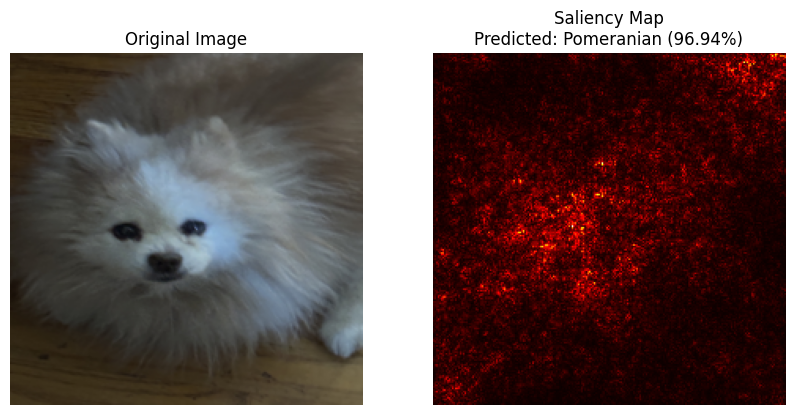

In [21]:
#sample test using jess's pet dog
test_prediction_with_saliency('./charlie.jpg')